## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
import collections

import numpy as np
import tensorflow as tf
import pickle
import random
import matplotlib.pyplot as plt

#import project_tests as tests

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, SimpleRNN, LSTM
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Activation, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-4/'


Mounted at /content/drive


In [3]:
# Load English data
english_sentences = open('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/COMP_EECE_7or8740_NNs/small_vocab_en', 'r', encoding='utf-8').read().split('\n')
# Load French data
french_sentences = open('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/COMP_EECE_7or8740_NNs/small_vocab_fr', 'r', encoding='utf-8').read().split('\n')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in small_vocab_en contains an English sentence with the respective translation in each line of small_vocab_fr. View the first two lines from each file.

In [ ]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary. A more complex vocabulary is a more complex problem. Let's look at the complexity of the dataset we'll be working with.

In [ ]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [ ]:
list(zip(*english_words_counter.most_common(10)))[0]

('is', ',', '.', 'in', 'it', 'during', 'the', 'but', 'and', 'sometimes')

## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:

Tokenize the words into ids
Add padding to make all the sequences the same length.
Time to start preprocessing the data...

#### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings. Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number. These are called character and word ids, respectively. Character ids are used for character level models that generate text predictions for each character. A word level model uses word ids that generate text predictions for each word. Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's Tokenizer function. Use this function to tokenize english_sentences and french_sentences in the cell below.

Running the cell will run tokenize on sample data and show output for debugging.

In [4]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)  
When batching the sequence of word ids together, each sequence needs to be the same length. Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the end of each sequence using Keras's pad_sequences function.

In [5]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

#tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline. Instead, we've provided you with the implementation of the preprocess function.

In [6]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    print(preprocess_y.shape)
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    print(preprocess_y.shape)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)
print(*preproc_french_sentences.shape)

(137861, 21)
(137861, 21, 1)
Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344
137861 21 1


### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want. We want the French translation. The function logits_to_text will bridge the gab between the logits from the neural network to the French translation. You'll be using this function to better understand the output of the neural network.

In [27]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1) if prediction != 0])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
![RNN](images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [ ]:
def stacked_RNN_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn1 = SimpleRNN(64, return_sequences = True)(input_seq)
    rnn2 = SimpleRNN(64, return_sequences=True)(rnn1)
    logits = TimeDistributed(Dense(french_vocab_size+1))(rnn2)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model

def stacked_LSTM_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn1 = LSTM(64, return_sequences = True)(input_seq)
    rnn2 = LSTM(64, return_sequences=True)(rnn1)
    logits = TimeDistributed(Dense(french_vocab_size+1))(rnn2)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model

def stacked_GRU_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn1 = GRU(64, return_sequences = True)(input_seq)
    rnn2 = GRU(64, return_sequences=True)(rnn1)
    logits = TimeDistributed(Dense(french_vocab_size+1))(rnn2)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model

#tests.test_simple_model(simple_model)



(137861, 21, 1)
21


In [8]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape)
print(preproc_french_sentences.shape[-2])


(137861, 21, 1)
21


In [ ]:
# Train the neural network
rnn_model = stacked_RNN_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

rnn_model.summary()

rnn_history = rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=128, epochs=150, validation_split=0.2)

base_dir = '/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-4/'
rnn_model.save(base_dir+'rnn_model.h5')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 21, 64)            4224      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 21, 64)            8256      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 21, 345)           22425     
_________________________________________________________________
activation_4 (Activation)    (None, 21, 345)           0         
Total params: 34,905
Trainable params: 34,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
862/862 [==============================] - 38s 42ms/step - loss: 1.9239 - accuracy: 0.5580 - val_loss: 1.4432

NameError: ignored

In [ ]:
# Train the LSTM
lstm_model = stacked_LSTM_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 21, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 64)            33024     
_________________________________________________________________
time_distributed (TimeDistri (None, 21, 345)           22425     
_________________________________________________________________
activation (Activation)      (None, 21, 345)           0         
Total params: 72,345
Trainable params: 72,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = lstm_model.fit(tmp_x, preproc_french_sentences, batch_size=128, epochs=150, validation_split=0.2)

lstm_model.save(base_dir+'lstm_model.h5')

history_file = 'lstm_train_history.p'

with open(base_dir+history_file, 'wb') as handle: # saving the history of the model trained for 150 Epochs
    pickle.dump(lstm_history.history, handle)

with open(base_dir+history_file, "rb") as file:
   e = pickle.load(file)
   print(e)

Epoch 1/150
862/862 [==============================] - 76s 84ms/step - loss: 2.1591 - accuracy: 0.5270 - val_loss: 1.5968 - val_accuracy: 0.5896
Epoch 2/150
862/862 [==============================] - 72s 83ms/step - loss: 1.4545 - accuracy: 0.6102 - val_loss: 1.3472 - val_accuracy: 0.6249
Epoch 3/150
862/862 [==============================] - 71s 83ms/step - loss: 1.2756 - accuracy: 0.6398 - val_loss: 1.2140 - val_accuracy: 0.6495
Epoch 4/150
862/862 [==============================] - 71s 83ms/step - loss: 1.1685 - accuracy: 0.6629 - val_loss: 1.1167 - val_accuracy: 0.6815
Epoch 5/150
862/862 [==============================] - 71s 82ms/step - loss: 1.0827 - accuracy: 0.6906 - val_loss: 1.0457 - val_accuracy: 0.6967
Epoch 6/150
862/862 [==============================] - 71s 82ms/step - loss: 1.0250 - accuracy: 0.7052 - val_loss: 0.9980 - val_accuracy: 0.7095
Epoch 7/150
862/862 [==============================] - 71s 82ms/step - loss: 0.9829 - accuracy: 0.7129 - val_loss: 0.9656 - val_ac

In [ ]:
# Train the GRU
gru_model = stacked_GRU_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

gru_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 21, 64)            12864     
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 64)            24960     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 345)           22425     
_________________________________________________________________
activation_1 (Activation)    (None, 21, 345)           0         
Total params: 60,249
Trainable params: 60,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_history = gru_model.fit(tmp_x, preproc_french_sentences, batch_size=128, epochs=150, validation_split=0.2)

gru_model.save(base_dir+'gru_model.h5')

history_file = 'gru_train_history.p'

with open(base_dir+history_file, 'wb') as handle: # saving the history of the model trained for 150 Epochs
    pickle.dump(gru_history.history, handle)

Epoch 1/150
862/862 [==============================] - 68s 74ms/step - loss: 2.1614 - accuracy: 0.5313 - val_loss: 1.6020 - val_accuracy: 0.5926
Epoch 2/150
862/862 [==============================] - 64s 74ms/step - loss: 1.4356 - accuracy: 0.6185 - val_loss: 1.3137 - val_accuracy: 0.6362
Epoch 3/150
862/862 [==============================] - 64s 74ms/step - loss: 1.2424 - accuracy: 0.6506 - val_loss: 1.1829 - val_accuracy: 0.6668
Epoch 4/150
862/862 [==============================] - 64s 74ms/step - loss: 1.1254 - accuracy: 0.6792 - val_loss: 1.0786 - val_accuracy: 0.6837
Epoch 5/150
862/862 [==============================] - 65s 75ms/step - loss: 1.0512 - accuracy: 0.6934 - val_loss: 1.0213 - val_accuracy: 0.6990
Epoch 6/150
862/862 [==============================] - 65s 75ms/step - loss: 1.0026 - accuracy: 0.7037 - val_loss: 0.9795 - val_accuracy: 0.7095
Epoch 7/150
862/862 [==============================] - 65s 75ms/step - loss: 0.9574 - accuracy: 0.7158 - val_loss: 0.9370 - val_ac

In [31]:
model = 'rnn_model.h5'
history_file = 'gru_train_history.p'

with open(base_dir+history_file, "rb") as file:
   e = pickle.load(file)

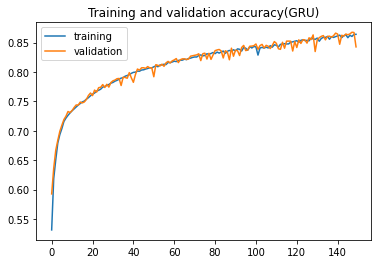

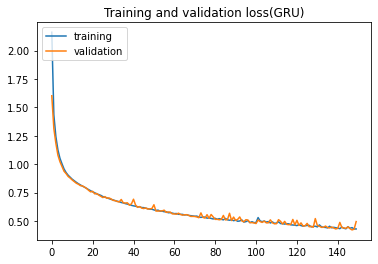

In [25]:
model_name = 'GRU'
plt.plot(e['accuracy'])
plt.plot(e['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy('+model_name+')')
plt.show()

plt.plot(e['loss'])
plt.plot(e['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss('+model_name+')')
plt.show()

In [32]:
random.seed(100)
random_sample = random.sample(range(tmp_x.shape[0]), 10)
print(random_sample)

model_loaded = tf.keras.models.load_model(base_dir+model)

for i in random_sample:
  prediction = model_loaded.predict(tmp_x[i:i+1])
  print(english_sentences[i])
  print(logits_to_text(prediction[0], french_tokenizer))
  print()

[38186, 120462, 119256, 45809, 103031, 91681, 113643, 132871, 28827, 31801]
the peach is her most loved fruit , but the mango is my most loved .
les pêche est son fruit le plus aimé mais la mangue est mon plus aimé

the peach is our favorite fruit , but the strawberry is his favorite .
les pêche est notre fruit préféré mais la fraise est son favori

the apple is her most loved fruit , but the grape is our most loved .
les pomme est son fruit le plus aimé mais le raisin est notre plus aimé

paris is never rainy during december , but it is usually mild in autumn .
paris est jamais pluvieux en décembre mais il est généralement doux en l' automne

he likes mangoes and peaches .
il aime les mangues et les pêches

i think it is difficult to translate between french and spanish .
ils pense qu'il est facile de traduire entre le et et

china is usually busy during fall , but it is rainy in august .
chine est généralement occupé en l' automne automne automne mais pluvieux en août août

new jerse

In [ ]:
90744
print(preproc_french_sentences.shape)
print(tmp_x.shape)

prediction = simple_rnn_model.predict(tmp_x[2:3])
print(logits_to_text(prediction[0], french_tokenizer))
print(prediction.shape)

(137861, 21, 1)
(137861, 21, 1)
californie est généralement chaud en l' et et est est calme en printemps <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
(1, 21, 345)
